# Sensor Correction Filter Synthesis

Text(0.5, 0, 'Frequency (Hz)')

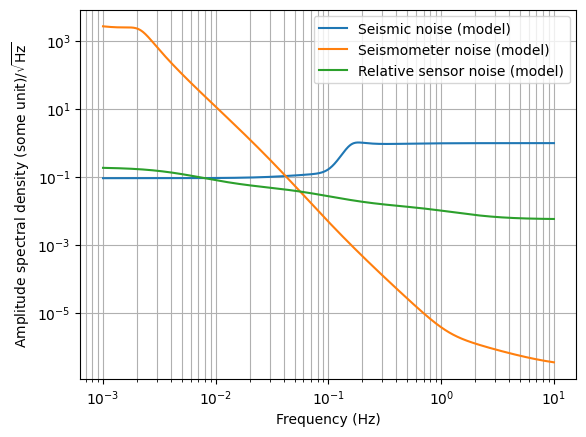

In [1]:
import pickle

import control
import numpy as np
import matplotlib.pyplot as plt

import kontrol


# Load the transfer function models 
tf_seismic = kontrol.load_transfer_function("tf_seismic.pkl")
tf_relative = kontrol.load_transfer_function("tf_relative.pkl")
tf_inertial = kontrol.load_transfer_function("tf_inertial.pkl")

# We've assumed the seismometer noise to be 2 times lower than that of the inertial sensors.
tf_seismometer = tf_inertial / 2

# Let's visualize before moving on
f = np.logspace(-3, 1, 1024)

plt.loglog(f, abs(tf_seismic(1j*2*np.pi*f)), label="Seismic noise (model)")
plt.loglog(f, abs(tf_seismometer(1j*2*np.pi*f)), label="Seismometer noise (model)")
plt.loglog(f, abs(tf_relative(1j*2*np.pi*f)), label="Relative sensor noise (model)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

Now, let's take a moment to think about how the sensor correction is going
to affect the noise of the relative sensor.

Without sensor correction, the effective noise of the relative sensor is
approximately the upper bound of the relative sensor (green curve) and the seismic noise (blue curve).
The blue curve domainates at high frequencies and that's what we want to get rid of
by means of sensor correction.

With sensor correction, we have the ability to suppress the blue curve.
However, this introduces seismometer noise (orange curve) to the relative sensor
and we want to suppress this as well.

The simultaneous suppression of seismic noise and seismometer noise constitute
a sensor fusion problem and we already have the tools to solve it as discussed in last section
of the advanced control methods tutorials.
However, if we do it that way, the seismic noise (blue) is going to be suppressed to a level
close to the seismometer noise (orange) at high frequencies.
While the traditional wisdom says we want to suppress seismic as much as possible, this is
not necessarily optimal.
This is because the relative sensor noise (green) is still in play and that is not being suppressed
by anything.
Any noise suppressed below that level is not useful as the corrected relative sensor noise is
going to be dominated by the relative sensor noise itself anyway.
Instead, we should indentify what is true lower boundary of the corrected relative sensor noise
and use that as the target attenuation.

In this case, the lower boundary is roughly the relative sensor noise except between
~$10^{-2}$ Hz and ~$5\times 10^{-2}$ Hz, where the seismic noise and seismometer noise dominates.
To do this propoerly, we should model that lower bound using a transfer function like how
we modelled other noise spectrums.
However, let's just assume that there's not much difference so we can use the relative sensor noise
as the lower boundary for simplicity.

In [2]:
# Synthesis
comp = kontrol.ComplementaryFilter()
comp.noise1 = tf_seismic
comp.noise2 = tf_seismometer
comp.weight1 = 1 / tf_relative  # Using the relative sensor noise as the lower boundary.
comp.weight2 = 1 / tf_relative
h1, h2 = comp.hinfsynthesis()

In [3]:
# Let's not forget about the prefilter.
s = control.tf("s")
wc = 2*np.pi*2e-3  # cut-off frequency
prefilter = (s / (s+wc))**3

# Redefine the sensor correction filter and seismic transmissivity
h2_prefilt = h2 * prefilter
h1_prefilt = 1 - h2_prefilt  # Complementary condition.

Text(0.5, 0, 'Frequency (Hz)')

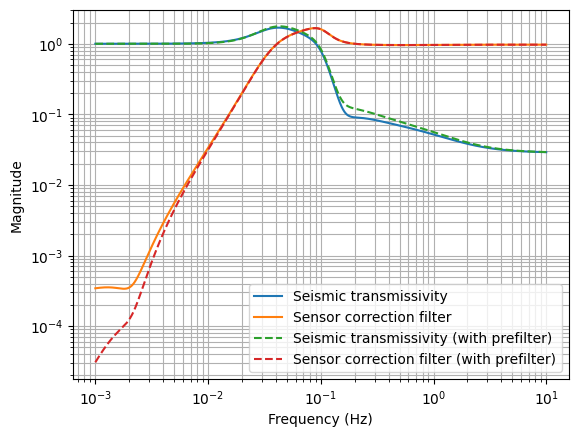

In [4]:
# Inspect
plt.loglog(f, abs(h1(1j*2*np.pi*f)), label="Seismic transmissivity")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), label="Sensor correction filter")
plt.loglog(f, abs(h1_prefilt(1j*2*np.pi*f)), "--", label="Seismic transmissivity (with prefilter)")
plt.loglog(f, abs(h2_prefilt(1j*2*np.pi*f)), "--", label="Sensor correction filter (with prefilter)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

In [5]:
# Let's forecast the noise of the corrected relative sensor.

# Load noise data
with open("noise_spectrum_relative.pkl", "rb") as fh:
    noise_relative = pickle.load(fh)
with open("noise_spectrum_seismometer.pkl", "rb") as fh:
    noise_seismometer = pickle.load(fh)
with open("noise_spectrum_seismic.pkl", "rb") as fh:
    noise_seismic = pickle.load(fh)
with open("noise_spectrum_frequency.pkl", "rb") as fh:
    f_ = pickle.load(fh)

Text(0.5, 0, 'Frequency (Hz)')

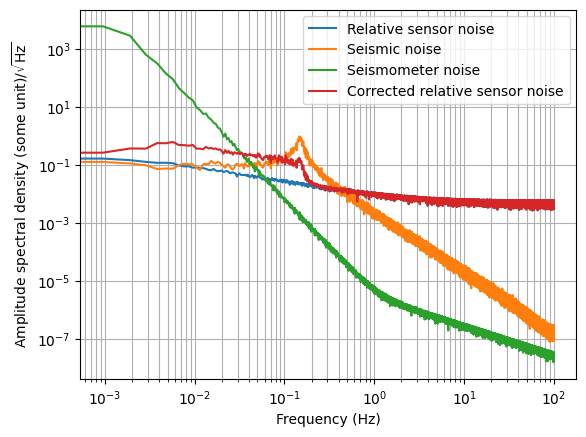

In [6]:
# The corrected relative sensor noise is composed of two components,
# the intrinsic relative sensor noise and the part related to sensor correction

# The part related to sensor correction:
noise_sensor_correction = comp.noise_super(f_, noise1=noise_seismic, noise2=noise_seismometer, filter1=h1_prefilt, filter2=h2_prefilt)

# The corrected relative sensor noise:
noise_corrected = kontrol.core.math.quad_sum(noise_relative, noise_sensor_correction)
# ^Remember, uncorrelated noises sum in quadrature (power).

# Visusalize
plt.loglog(f_, noise_relative, label="Relative sensor noise")
plt.loglog(f_, noise_seismic, label="Seismic noise")
plt.loglog(f_, noise_seismometer, label="Seismometer noise")
plt.loglog(f_, noise_corrected, label="Corrected relative sensor noise")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

In [7]:
# Now we're seeing some reduction especially around the secondary microseim.
# However, we're also injecting noise at lower frequency.
# To justify this tradeoff, let's compare the RMS of the seismic noise and the corrected relative sensor
print("Seismic noise RMS:", kontrol.spectral.asd2rms(noise_seismic, f=f_, return_series=False))
print("Corrected relative sensor RMS:", kontrol.spectral.asd2rms(noise_corrected, f=f_, return_series=False))

Seismic noise RMS: 0.1434520357166474
Corrected relative sensor RMS: 0.10451631749875732


In [8]:
# As you can see, with the sensor correction scheme, the noise RMS is lowered,
# given that the RMS of an uncorrected relative sensor is mostly contributed from the seismic noise.
# (we aren't even minimizing the RMS with H2 optimization)
# Of course, this is not always true in reality and this is only an example with mock data.

# And, the corrected relative sensor noise is the one that we need to model for sensor fusion!

# Export the sensor correction filter.
print("Sensor correction filter:\n", kontrol.TransferFunction(h2_prefilt).foton(root_location="n"))

Sensor correction filter:
 zpk([-0;-0;-0;0.000634057;0.000567+i*0.002048;0.000567+i*-0.002048;0.0155221;0.0332424;0.102979;0.048242+i*0.106069;0.048242+i*-0.106069;0.814654;2.06538],[0.00199992;0.002000+i*0.000000;0.002000+i*-0.000000;0.00376468;0.022393+i*0.030733;0.022393+i*-0.030733;0.050882+i*0.005582;0.050882+i*-0.005582;0.0563568;0.033088+i*0.096811;0.033088+i*-0.096811;0.837395;2.06538],29011.4,"n")
